In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io.votable import parse


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Making an SED becasue that's my job

In [2]:
tphot = 'eg_uma_vizier_phot.vot'
c = 2.998e8*u.m/u.s



votable = parse(tphot)
table = votable.get_first_table()
data = table.array
mask = ~data['sed_eflux'].mask
masked_data = data[mask].data
filters = np.unique(masked_data['sed_filter'].data)
wp = []
fp = []
ep = []
print(filters)

filters = ['2MASS:H', '2MASS:J', '2MASS:Ks', 'GALEX:FUV'
 ,'GALEX:NUV', 'Gaia:G', "SDSS:g'" , "SDSS:i'" , "SDSS:r'"
 , "SDSS:u'" , "SDSS:z'" ,'WISE:W1', 'WISE:W2', 'WISE:W3',
 'WISE:W4']

for flt in filters:
    w1 = (np.mean(masked_data['sed_freq'][masked_data['sed_filter']==flt])*u.GHz).to(u.AA, equivalencies=u.spectral())
    fj1 = masked_data['sed_flux'][masked_data['sed_filter']==flt]
    e1 = masked_data['sed_eflux'][masked_data['sed_filter']==flt]
    if len(fj1) >1:
        fj_av = np.average(fj1, weights = (1/(e1**2)))
        e1_av = abs(np.average((fj1-fj_av), weights = (1/(e1**2))))**0.5
        e1_av = 1 / np.sum(1/(e1**2), axis=0)**0.5
    else:
        fj_av, e1_av = fj1[0], e1[0]
    f1 = (fj_av*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(w1)) 
    wp.append(w1.value)
    fp.append(f1.value)
    e1 = ((e1_av*f1)/fj_av).value
    ep.append(e1)

wp, fp, ep = np.array(wp), np.array(fp), np.array(ep)

# plt.figure(figsize=(5, 5))
# plt.errorbar(wp[ep>0], fp[ep>0], yerr=ep[ep>0], marker='o', ls='none', c='C0')
# plt.xscale('log')
# plt.yscale('log')

['2MASS:H' '2MASS:J' '2MASS:Ks' ':=3.6um' ':=5.8um' 'GALEX:FUV'
 'GALEX:NUV' 'Gaia:G' 'Johnson:B' 'Johnson:H' 'Johnson:J' 'Johnson:K'
 'Johnson:V' 'PAN-STARRS/PS1:y' 'PAN-STARRS/PS1:z' 'POSS-II:F' 'POSS-II:J'
 'POSS-II:i' 'SDSS:g' "SDSS:g'" 'SDSS:i' "SDSS:i'" 'SDSS:r' "SDSS:r'"
 'SDSS:u' "SDSS:u'" 'SDSS:z' "SDSS:z'" 'WISE:W1' 'WISE:W2' 'WISE:W3'
 'WISE:W4']


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in float_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


In [3]:
cpath = '/media/david/5tb_storage1/pceb_data/eg_uma/'
x = glob.glob('{}*x1dsum.fits'.format(cpath))[0]

smooth=5
data = fits.getdata(x, 1)
wc = np.array([], dtype=float)
fc = np.array([], dtype=float)
ec = np.array([], dtype=float)
for dt in data[::-1]:
    wi, fi, ei, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
   # mask = (fi>0) & (dq == 0) & (wi < 1213) | (wi > 1217) & (fi>0) & (dq == 0) 
    mask = (dq==0)
    wi, fi, ei = wi[mask], fi[mask], ei[mask]
    wc = np.concatenate((wc, wi))
    fc = np.concatenate((fc, fi))
    ec = np.concatenate((ec, ei))    

fc = convolve(fc,Box1DKernel(smooth))
ec = convolve(ec,Box1DKernel(smooth))/(smooth**0.5)

# plt.plot(wc, fc)

mask = (wc < 1210) | (wc > 1220) 
wc1, fc1, ec1 = wc[mask], fc[mask], ec[mask]

In [4]:
path = '/media/david/5tb_storage1/eg_uma/hst/stis/data/'
x1ds = glob.glob('{}*x1d.fits'.format(path))

data = fits.getdata(x1ds[0])[0]
ws, fs, es = data['WAVELENGTH'], data['FLUX'], data['ERROR']

In [5]:
data = Table.read('spect.V EG UMa.Gianninas.txt', format='ascii')
# wo, fo = data['wavelength']*u.AA, data['flux']*u.mJy#u.erg/u.s/u.cm**2/u.AA
wo, fo = data['wavelength']*u.AA, data['flux']*u.J/u.s/u.cm**2/u.AA

# plt.plot(wo, fo)

In [6]:
mw, mf = np.loadtxt('scaled_eguma_model.dat', unpack=True)

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


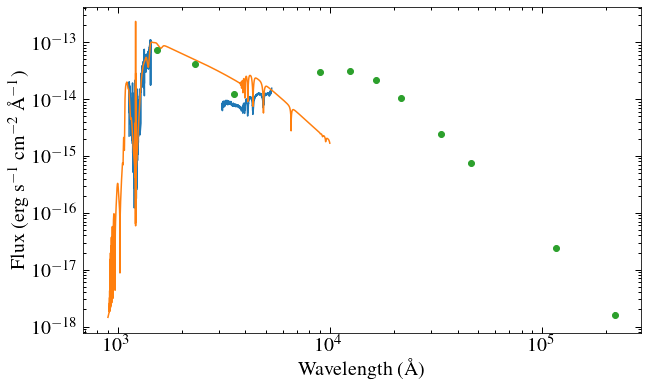

In [7]:
plt.figure(figsize=(10, 6))
mask = (wc < 1210) & (fc>0)
plt.plot(wc[mask], fc[mask], c='C0')
mask = (wc > 1220) & (fc>0)
plt.plot(wc[mask], fc[mask], c='C0', label='COS')
mask = (ws > 1210) & (ws < 1220) & (fs>0)
plt.plot(ws[mask], fs[mask], c='C1', label='STIS')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# plt.legend(frameon=True)
# plt.xlim(1140, 1420)
# plt.ylim(-0.1e-13, 1e-13)

# plt.plot([wc[0], wc[-1]], [3e-13, 3e-13], c='C1')
plt.errorbar(wp[ep>0], fp[ep>0], yerr=ep[ep>0], marker='o', ls='none', c='C2')

# plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wo)))
# plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA))
plt.plot(wo, fo*1e11)
plt.plot(mw, mf)

# plt.xlim(1000, 2000)
plt.xscale('log')
plt.yscale('log')

(0.0, 4e-14)

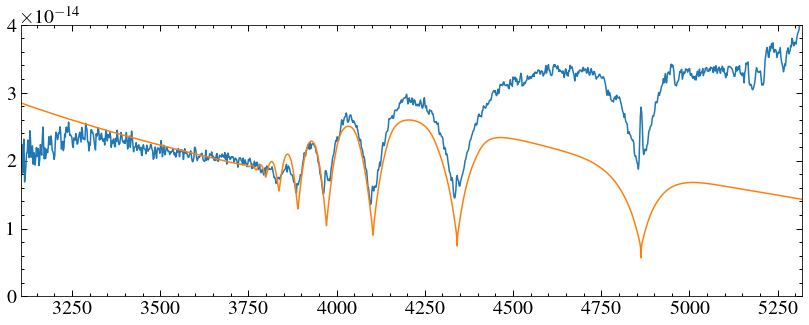

In [8]:
plt.plot(wo, fo*2.7e11)
plt.plot(mw, mf)
plt.xlim(wo[0].value, wo[-1].value)
plt.ylim(0, 0.4e-13)

adding gj1132 to compare

In [9]:
data = Table.read('/media/david/5tb_storage1/muscles/basic_seds/GJ1132_basic_v1.ecsv')
gjw, gjf = data['WAVELENGTH'], data['FLUX']

d_gj = 12.038
d_eg = 28.71
gjf = gjf*(d_gj/d_eg)**2
# plt.plot(gjw, gjf)

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


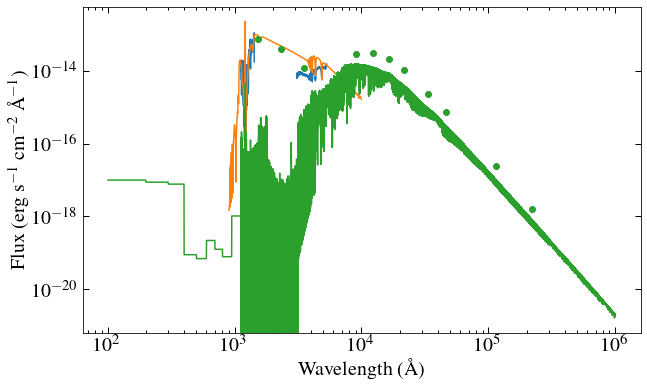

In [10]:
plt.figure(figsize=(10, 6))
mask = (wc < 1210) & (fc>0)
plt.plot(wc[mask], fc[mask], c='C0')
mask = (wc > 1220) & (fc>0)
plt.plot(wc[mask], fc[mask], c='C0', label='COS')
mask = (ws > 1210) & (ws < 1220) & (fs>0)
plt.plot(ws[mask], fs[mask], c='C1', label='STIS')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# plt.legend(frameon=True)
# plt.xlim(1140, 1420)
# plt.ylim(-0.1e-13, 1e-13)

# plt.plot([wc[0], wc[-1]], [3e-13, 3e-13], c='C1')
plt.errorbar(wp[ep>0], fp[ep>0], yerr=ep[ep>0], marker='o', ls='none', c='C2')

# plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wo)))
# plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA))
plt.plot(wo, fo*1e11)
plt.plot(mw, mf)

plt.plot(gjw, gjf)

# plt.xlim(1000, 2000)
plt.xscale('log')
plt.yscale('log')

Just the UV

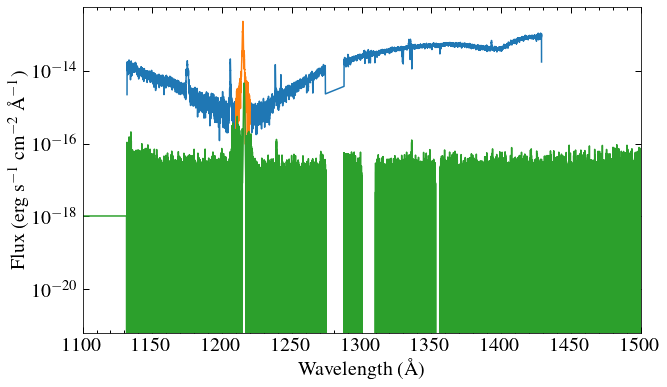

In [11]:
plt.figure(figsize=(10, 6))
mask = (wc < 1210) & (fc>0)
plt.plot(wc[mask], fc[mask], c='C0')
mask = (wc > 1220) & (fc>0)
plt.plot(wc[mask], fc[mask], c='C0', label='COS')
mask = (ws > 1210) & (ws < 1220) & (fs>0)
plt.plot(ws[mask], fs[mask], c='C1', label='STIS')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# plt.legend(frameon=True)
# plt.xlim(1140, 1420)
# plt.ylim(-0.1e-13, 1e-13)

# plt.plot([wc[0], wc[-1]], [3e-13, 3e-13], c='C1')
# plt.errorbar(wp[ep>0], fp[ep>0], yerr=ep[ep>0], marker='o', ls='none', c='C2')

# plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wo)))
# plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA))
# plt.plot(wo, fo*1e11)
# plt.plot(mw, mf)

plt.plot(gjw, gjf, c='C2')

plt.xlim(1100, 1500)

# plt.xscale('log')
plt.yscale('log')

Teff of the secondary could be off becasue they didn't have the distance. Urggh, do I need to write a PCEB fitting routine?

Just the UV then

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


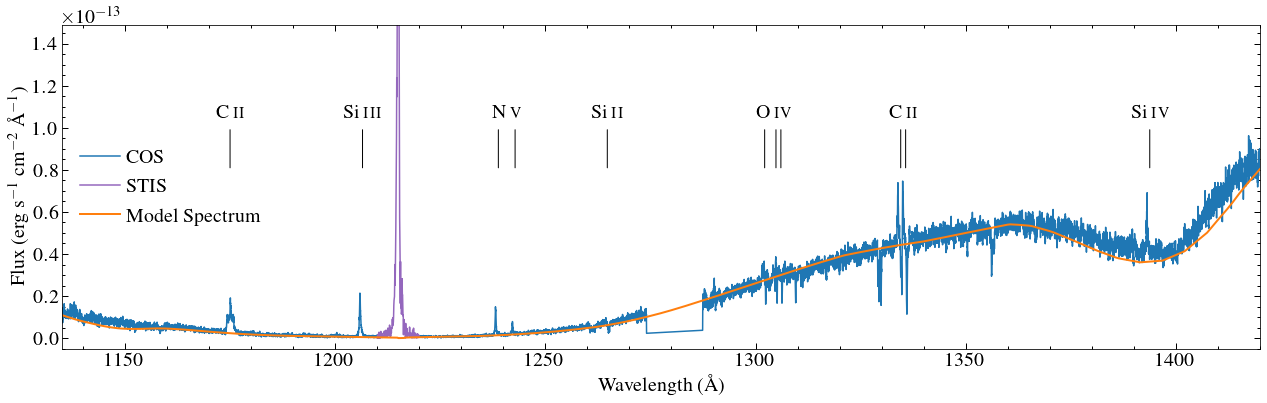

In [12]:
plt.figure(figsize=(18, 6))
mask = (wc < 1210) & (fc>0)
plt.plot(wc[mask], fc[mask], c='C0')
mask = (wc > 1220) & (fc>0)
plt.plot(wc[mask], fc[mask], c='C0', label='COS')
mask = (ws > 1210) & (ws < 1220) & (fs>0)
plt.plot(ws[mask], fs[mask], c='C4', label='STIS')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.plot(mw, mf, c='C1', lw=2, label= 'Model Spectrum')

si2 = [1264.738]
si3 = [1294.545,1296.726,1298.892,1301.149,1303.323,1312.591]
si4 = [1393.775]#,1402.770]
o1 = [1302.17,1304.86,1306.03]
c2 = [1334.532, 1335.703]
c2i = [1175]
si3i = [1206.51]
nv = [1238.821,1242.804]

names = ['Si\,{\sc ii}', 'Si\,{\sc iv}', 'O\,{\sc iv}', 'C\,{\sc ii}', 'C\,{\sc ii}', 'Si\,{\sc iii}', 'N\,{\sc v}']
lines = [si2, si4, o1,c2, c2i, si3i, nv]
for name, si in zip(names, lines):
    [plt.annotate('',(line, 0.8e-13), xytext=(line, 1.0e-13),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si]
    plt.annotate(name,(np.mean(si), 1.e-13), xytext=(np.mean(si), 1.05e-13), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))

# plt.plot(gjw, gjf, c='C2')

plt.xlim(1135, 1420)
plt.ylim(-0.05e-13, 1.49e-13)
plt.legend(loc=6)
plt.tight_layout()
# plt.xscale('log')
# plt.yscale('log')
plt.savefig('plots/eg_uma_fuv.pdf', dpi=150)


Can I fit the CII lines?

[1.171]
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5] + [6]
Components: 
    [0]: <Polynomial1D(2, c0=-0., c1=0., c2=-0.)>

    [1]: <Gaussian1D(amplitude=0., mean=1333.87162332, stddev=0.1266403)>

    [2]: <Gaussian1D(amplitude=-0., mean=1334.6730653, stddev=0.15649918)>

    [3]: <Gaussian1D(amplitude=-0., mean=1334.84076162, stddev=0.05989639)>

    [4]: <Gaussian1D(amplitude=0., mean=1335.04262332, stddev=0.13902408)>

    [5]: <Gaussian1D(amplitude=-0., mean=1335.8440653, stddev=0.11051415)>

    [6]: <Gaussian1D(amplitude=-0., mean=1336.01176162, stddev=0.09942463)>
Parameters:
             c0_0                   c1_0          ...       stddev_6     
    ---------------------- ---------------------- ... -------------------
    -1.258907467501549e-10 1.8820196319419552e-13 ... 0.09942463237965825


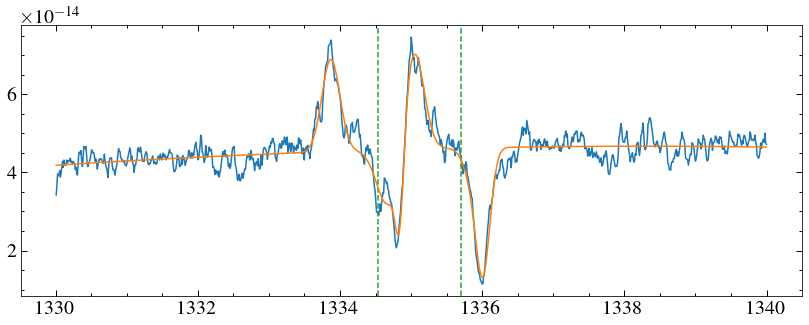

In [40]:
def tiedfunc0(gg_init):
    mean = gg_init.mean_1.value+1.171
    mean = gg_init.mean_1.value+1.171
    return mean

def tiedfunc1(gg_init):
    mean = gg_init.mean_2.value+1.171
    return mean

def tiedfunc2(gg_init):
    mean = gg_init.mean_3.value+1.171
    return mean

fitter = fitting.LevMarLSQFitter()
c2 = [1334.532, 1335.703]
print(np.diff(c2))

cmask = (wc > 1330) & (wc < 1340)
wline, fline, eline, =wc[cmask], fc[cmask], ec[cmask]
plt.plot(wline,fline)

models.Polynomial1D(2)
gg_init = models.Polynomial1D(2)
dv_guess = np.array([-150, 0, +70])*u.km/u.s
stds = [0.1, 0.05, 0.1]
amps =[2e-14, -1e-14, -2e-14]
for line in c2:
    for i, dv in enumerate(dv_guess):
        guess_line = dv.to(u.AA,  equivalencies=u.doppler_optical(line*u.AA)).value
        gg_init += models.Gaussian1D(amps[i], guess_line, stds[i])
gg_init.mean_4.tied=tiedfunc0
gg_init.mean_5.tied=tiedfunc1
gg_init.mean_6.tied=tiedfunc2

gg_fit = fitter(gg_init, wline, fline, weights=1/eline, maxiter=100000)
[plt.axvline(line,ls='--', c='C2') for line in c2]
plt.plot(wline, gg_fit(wline))
print(gg_fit)
